In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import numpy as np
import pandas as pd
from gsprep.visual_tools.visual import idisplay, display
from scipy import ndimage
import nibabel as nib
import os

# Measuring lesion water uptake in region defined by final infarct

%water uptake = (1 − (Dischemic / Dnormal) × 100

In [41]:
imaging_dataset_path = '/Users/jk1/stroke_datasets/dataset_files/perfusion_data_sets/with_ncct_dataset_with_onset_to_imaging.npz'
label_file_path = '/Users/jk1/OneDrive - unige.ch/stroke_research/geneva_stroke_dataset/clinical_data/multi_annual_joined_data/scope_joined_variables/onset_prediction/with_imaging_curated_completed_joined_anon_outcome_df.xlsx'

id_variable = 'pid'
outcome = 'onset_to_imaging'
channels = [0,1,2,3,4]
apply_csf_mask = True

In [42]:

ids = np.load(imaging_dataset_path, allow_pickle=True)['ids']

outcomes_df = pd.read_excel(label_file_path)

selected_ids = [outcomes_df[id_variable].str.contains(ids[i]).any() for i in range(len(ids))]

ids = ids[selected_ids]

labels = np.array([outcomes_df.loc[outcomes_df[id_variable] == subj_id, outcome].iloc[0] for
                   subj_id in ids])

In [43]:

raw_images = np.load(imaging_dataset_path, allow_pickle=True)['ct_inputs'][..., channels]
raw_lesion_GT = np.load(imaging_dataset_path, allow_pickle=True)['ct_lesion_GT']


if raw_images.ndim < 5:
    raw_images = np.expand_dims(raw_images, axis=-1)

# Apply masks
raw_masks = np.load(imaging_dataset_path, allow_pickle=True)['brain_masks']
lesion_GT = raw_lesion_GT * raw_masks
raw_masks = np.expand_dims(raw_masks, axis=-1)
images = raw_images * raw_masks

In [44]:
lesion_GT = lesion_GT[selected_ids]
images = images[selected_ids]

In [45]:
n_subj = len(ids)

ncct = images[..., 4]

mirrored_lesion_GT = np.flip(lesion_GT, axis=1)

In [46]:
from gsd_pipeline.dataset_tools.add_core_map import dilation_structure_2d
from gsprep.utils.smoothing import gaussian_smoothing

dilation_structure = dilation_structure_2d

# Create CSF mask
low_bounded_ncct = ncct[ncct > 0]
up_and_low_bounded_ncct = low_bounded_ncct[low_bounded_ncct < 100]
# threshold = 20
threshold = np.percentile(up_and_low_bounded_ncct, 5)
csf_mask = gaussian_smoothing(ncct[..., None], kernel_width=3) < threshold
enlarged_csf_mask = np.array(
    [ndimage.binary_dilation(csf_mask[idx, ..., 0], structure=dilation_structure(2)) for idx in range(csf_mask.shape[0])])
inv_csf_mask = -1 * enlarged_csf_mask + 1

In [47]:
if apply_csf_mask:
    lesion_GT = lesion_GT * inv_csf_mask
    mirrored_lesion_GT = mirrored_lesion_GT * inv_csf_mask

In [48]:
np.argmax(np.sum(lesion_GT, axis=(1,2,3)))

74

Image center:  39 47 39
Image center value:  21.0


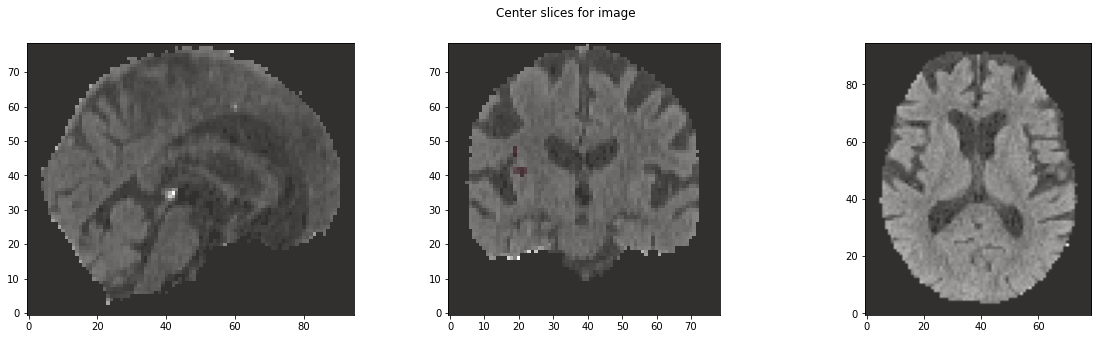

Image center:  39 47 39
Image center value:  21.0


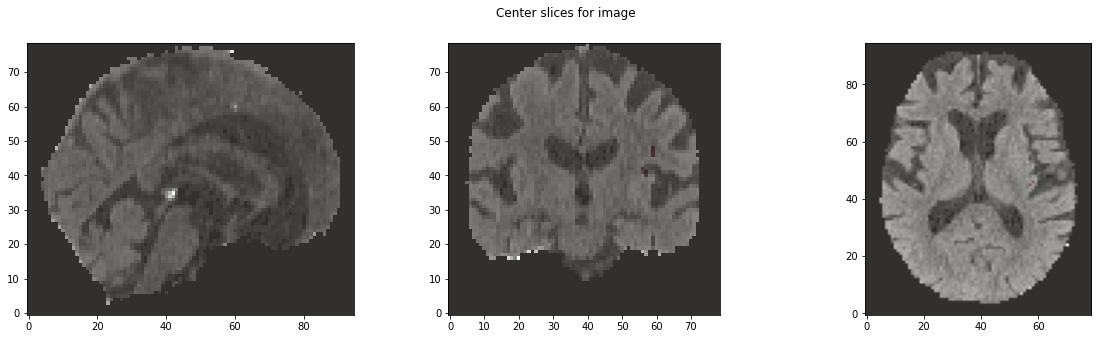

In [49]:
i_subj = 1

display(images[i_subj,...,4], mask=lesion_GT[i_subj])
display(images[i_subj,...,4], mask=mirrored_lesion_GT[i_subj])

In [50]:
mean_ischemic_density = [np.mean(ncct[i][np.nonzero(lesion_GT[i])])
                                 for i in range(n_subj)]

mean_non_ischemic_density = [np.mean(ncct[i][np.nonzero(mirrored_lesion_GT[i])])
                                 for i in range(n_subj)]

/Users/jk1/opt/anaconda3/envs/scope/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jk1/opt/anaconda3/envs/scope/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [51]:
water_uptake = (1 - np.divide(mean_ischemic_density, mean_non_ischemic_density)) * 100

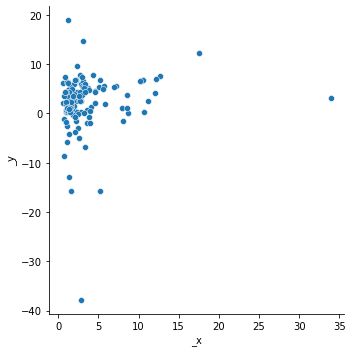

In [52]:
g = sns.relplot(x=labels/60, y=water_uptake)

[]

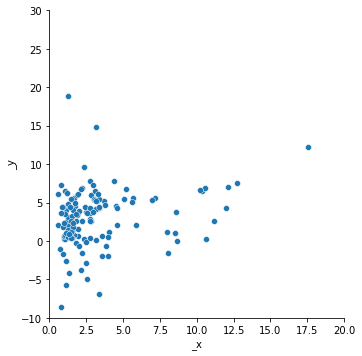

In [53]:
g = sns.relplot(x=labels/60, y=water_uptake)
g.ax.set_xlim(0,20)
g.ax.set_ylim(-10,30)
plt.plot()


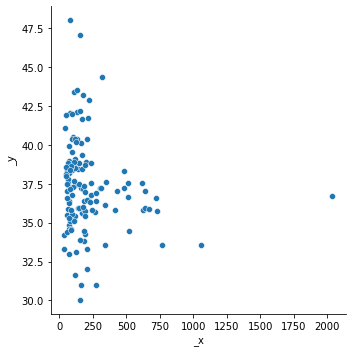

In [54]:
sns.relplot(x=labels, y=mean_ischemic_density)

In [55]:
binary_labels = labels > 4.5*60

# replace nan with 0
water_uptake = np.nan_to_num(water_uptake)

metrics.roc_auc_score(binary_labels, water_uptake)

0.6089422756089422

In [56]:
metrics.roc_auc_score(binary_labels, np.nan_to_num(mean_ischemic_density))

0.3573573573573574

In [57]:
df = pd.DataFrame(zip(labels, binary_labels, mean_ischemic_density, mean_non_ischemic_density, water_uptake),
                  columns=['onset_to_imaging', 'binary_labels', 'mean_ischemic_density', 'mean_non_ischemic_density', 'water_uptake'])

In [58]:
df['mean_ischemic_density'].describe()

count    137.000000
mean      37.348265
std        2.935175
min       30.036364
25%       35.711148
50%       37.189474
75%       38.703744
max       48.000000
Name: mean_ischemic_density, dtype: float64

In [59]:
df['mean_non_ischemic_density'].describe()

count    137.000000
mean      38.316088
std        2.928933
min       29.180328
25%       36.808725
50%       38.582278
75%       39.933905
max       48.925527
Name: mean_non_ischemic_density, dtype: float64

In [60]:
print(df[df['binary_labels'] == 0]['mean_ischemic_density'].describe())
print(df[df['binary_labels'] == 0]['mean_non_ischemic_density'].describe())
print(df[df['binary_labels'] == 0]['water_uptake'].describe())


count    111.000000
mean      37.574702
std        3.029212
min       30.036364
25%       35.615882
50%       37.434047
75%       38.876944
max       48.000000
Name: mean_ischemic_density, dtype: float64
count    111.000000
mean      38.452041
std        3.140307
min       29.180328
25%       36.741958
50%       38.741760
75%       40.295214
max       48.925527
Name: mean_non_ischemic_density, dtype: float64
count    111.000000
mean       2.109209
std        5.820953
min      -37.809984
25%        0.473196
50%        2.618960
75%        4.841986
max       18.882078
Name: water_uptake, dtype: float64


In [61]:
print(df[df['binary_labels'] == 1]['mean_ischemic_density'].describe())
print(df[df['binary_labels'] == 1]['mean_non_ischemic_density'].describe())
print(df[df['binary_labels'] == 1]['water_uptake'].describe())


count    26.000000
mean     36.381554
std       2.300532
min      30.989547
25%      35.809365
50%      36.601677
75%      37.202608
max      44.333333
Name: mean_ischemic_density, dtype: float64
count    26.000000
mean     37.735675
std       1.686627
min      32.399705
25%      37.032899
50%      38.238647
75%      38.616262
max      40.222222
Name: mean_non_ischemic_density, dtype: float64
count    27.000000
mean      3.428096
std       4.850598
min     -15.652174
25%       1.560094
50%       4.352379
75%       6.074384
max      12.265489
Name: water_uptake, dtype: float64


In [81]:
subj_id = 99
ids[subj_id]

'subj-5af90b8b'

In [82]:
mean_ischemic_density[subj_id]

37.55555555555556

In [83]:
mean_non_ischemic_density[subj_id]

40.22222222222222

In [84]:
water_uptake[subj_id]

6.62983425414364

In [85]:
labels[subj_id]/60

10.233333333337214

In [86]:
output_dir = '/Users/jk1/temp/scope_onset_exploration'

ncct_img = nib.Nifti1Image(ncct[subj_id], np.eye(4))
nib.save(ncct_img, os.path.join(output_dir, f'{ids[subj_id]}_ncct.nii'))

mask_img = nib.Nifti1Image(raw_masks[subj_id].astype(int), np.eye(4))
nib.save(mask_img, os.path.join(output_dir, f'{ids[subj_id]}_mask.nii'))


lesion_img = nib.Nifti1Image(lesion_GT[subj_id], np.eye(4))
nib.save(lesion_img, os.path.join(output_dir, f'{ids[subj_id]}_lesion.nii'))

mirrored_lesion_img = nib.Nifti1Image(mirrored_lesion_GT[subj_id], np.eye(4))
nib.save(mirrored_lesion_img, os.path.join(output_dir, f'{ids[subj_id]}_mirrored_lesion.nii'))

csf_img = nib.Nifti1Image(enlarged_csf_mask[subj_id].astype(int), np.eye(4))
nib.save(csf_img, os.path.join(output_dir, f'{ids[subj_id]}_csf.nii'))

In [80]:
np.where(ids == 'subj-5af90b8b')

(array([99]),)